In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd

from antenna_utils import *

In [352]:
def uv_coverage(baselines, n_antennas,x_lim,y_lim):
    N_grid = int(np.sqrt(4/np.sqrt(3)*n_antennas*(n_antennas-1)))
    uv_grids, _, _ = np.histogram2d(baselines[:,0],baselines[:,1],bins=N_grid, range=[[-x_lim,x_lim],[-y_lim,y_lim]])
    return (uv_grids.size - np.sum(uv_grids==0, axis=(0,1)))/N_grid**2

In [353]:
class Y_ARRAY:

    def __init__(self,n_antenna_per_arm=8, type='random', radius=21000, D=25, alpha=5, latitud = 34, uv_dim=128):
        self.alpha_list = [alpha, alpha+120, alpha+240]
        self.n_antenna = int(n_antenna_per_arm*3)
        self.radius =  radius
        self.D = D
        self.n_baselines = self.n_antenna*(self.n_antenna-1)
        self.lat = latitud
        self.uv_dim=uv_dim
        self.array = np.zeros((self.n_antenna,2))
        self.baselines = np.zeros((self.n_baselines, 2))
        self.uv_plane = np.zeros((self.uv_dim, self.uv_dim))

        self.init_array_params(type)
        

    def init_array_params(self, type='uniform', x=None):
        if type == 'uniform':
            self.x = np.linspace(start=self.radius/self.n_antenna/3,stop=self.radius,num=int(self.n_antenna/3))
        elif type == 'random':
            self.x = rnd.randint(1,int(self.radius/self.D),int(self.n_antenna/3))*self.D
        elif type == 'custom':
            self.x = x
        self.compute_array()
        self.compute_baselines()
        
    def compute_array(self,):
        self.array = np.array([ [np.array([ant*np.cos(angle/180*np.pi), ant*np.sin(angle/180*np.pi)]) for ant in self.x] for angle in self.alpha_list ]).reshape((self.n_antenna,2))

    def compute_baselines(self):
        self.baselines = get_baselines(self.array)

    def time_integrate_baselines(self, lat=34, source_declination=34, track_time=8, delta_t=5/60, t_0=-2):
        self.compute_baselines()
        self.baselines = uv_time_int(self.baselines, lat/180*np.pi, source_declination/180*np.pi, track_time, delta_t, t_0)

    def compute_uv_plane(self,):
        self.uv_plane = get_uv_plane(self.baselines,self.uv_dim)

    def uv_coverage(self):
        x_lim = self.radius*1.1
        y_lim = self.radius*1.1
        return uv_coverage(self.baselines, self.n_antenna, x_lim=x_lim ,y_lim=y_lim)
        

In [354]:
class SWARM:

    def __init__(self, n_agents=10, init='random'):
        self.n_agents = n_agents
        self.agents = [Y_ARRAY(type=init) for i in range(self.n_agents)]
        # Best agent tracking
        self.global_best = [0, np.zeros(self.agents[0].x.shape)]
        self.personal_best = [np.zeros(self.n_agents), np.array([np.zeros(self.agents[0].x.shape) for i in range(self.n_agents)])]
        self.velocity = np.array([np.zeros(self.agents[0].x.shape) for i in range(self.n_agents)])
    
    def fitness(self,):
        return np.array([agent.uv_coverage() for agent in self.agents])

    def compute_baselines(self):
        [agent.compute_baselines() for agent in self.agents]

    def compare_agents(self,):
        # Compute fitess for every agent
        fitness = self.fitness()
        # Update personal best and fitness values
        update_idx = np.where(fitness > self.personal_best[0])
        self.personal_best[1][update_idx] = np.array([agent.x for agent in self.agents])[update_idx]
        self.personal_best[0][update_idx] = fitness[update_idx]
        # Find best agent
        self.global_best[0] = np.max(self.personal_best[0])
        self.global_best[1] = self.personal_best[1][np.argmax(self.personal_best[0])]

    def update_agents(self,w=0.6,c1=2,c2=2):
        n1,n2 = rnd.randn(2)
        V = self.velocity
        P = self.personal_best[1]
        X = np.array([agent.x for agent in self.agents])
        G = np.stack([self.global_best[1] for _ in range(self.n_agents)])
        # compute velocity V(t+1)
        self.velocity = w*V + c1*n1*(P-X) + c2*n2*(G-X)
        X = X+self.velocity
        [agent.init_array_params(type='custom', x=x) for agent,x in zip(self.agents,X)]


In [358]:
swarm = SWARM(n_agents=10)

n_epochs = 500
for epoch in range(n_epochs):
    swarm.compare_agents()
    swarm.update_agents(w=0.4,c1=.5, c2=.5)
    if np.mod(epoch,int(n_epochs/20)) == 0:
        print('epoch {:2} - Promoted Agent: #{:2} - fitness: {:1.3}'.format(epoch, np.argmax(swarm.personal_best[0]),swarm.global_best[0]))



epoch  0 - Promoted Agent: # 9 - fitness: 0.265
epoch 25 - Promoted Agent: # 3 - fitness: 0.333
epoch 50 - Promoted Agent: # 1 - fitness: 0.336
epoch 75 - Promoted Agent: # 8 - fitness: 0.34
epoch 100 - Promoted Agent: # 0 - fitness: 0.34
epoch 125 - Promoted Agent: # 0 - fitness: 0.341
epoch 150 - Promoted Agent: # 0 - fitness: 0.341
epoch 175 - Promoted Agent: # 0 - fitness: 0.341
epoch 200 - Promoted Agent: # 0 - fitness: 0.341
epoch 225 - Promoted Agent: # 0 - fitness: 0.341
epoch 250 - Promoted Agent: # 0 - fitness: 0.341
epoch 275 - Promoted Agent: # 0 - fitness: 0.341
epoch 300 - Promoted Agent: # 0 - fitness: 0.341
epoch 325 - Promoted Agent: # 0 - fitness: 0.341
epoch 350 - Promoted Agent: # 0 - fitness: 0.341
epoch 375 - Promoted Agent: # 0 - fitness: 0.341
epoch 400 - Promoted Agent: # 0 - fitness: 0.341
epoch 425 - Promoted Agent: # 0 - fitness: 0.341
epoch 450 - Promoted Agent: # 0 - fitness: 0.341
epoch 475 - Promoted Agent: # 0 - fitness: 0.341


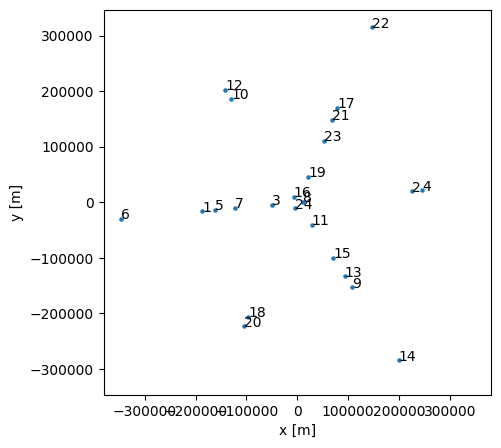

In [359]:
plot_antenna_arr(swarm.agents[0].array)

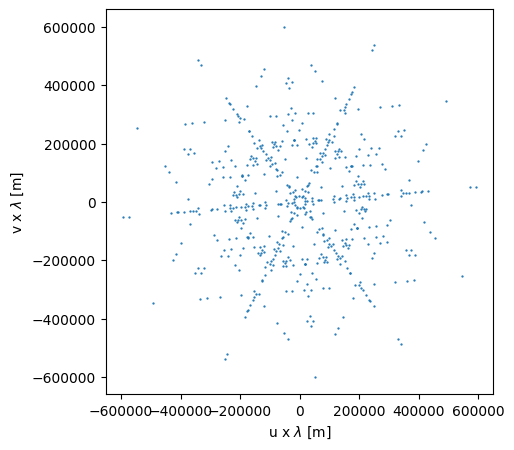

In [360]:
plot_uv_plane(swarm.agents[0].baselines)

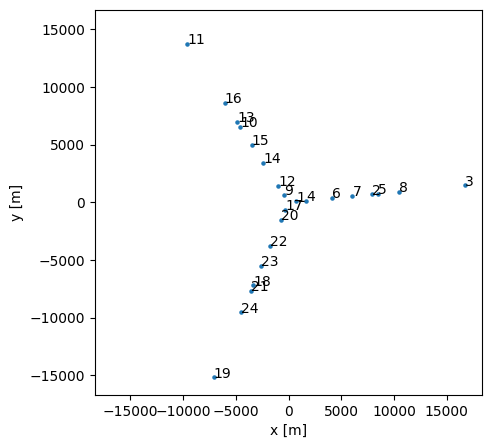

In [57]:
# antenna parametrization
x = np.array([3,6,9,12,15,18,21,24,27,30])*10e3
Y = Y_ARRAY(n_antenna_per_arm=8, type='random', radius=21000, D=25, alpha=5, latitud = 34, uv_dim=128)
Y.compute_array()
plot_antenna_arr(Y.array)

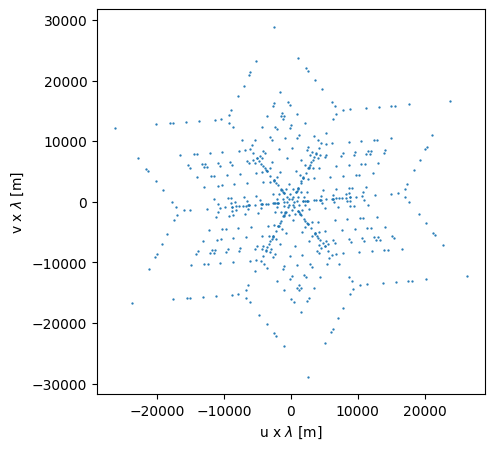

In [58]:
Y.compute_baselines()
plot_uv_plane(Y.baselines)

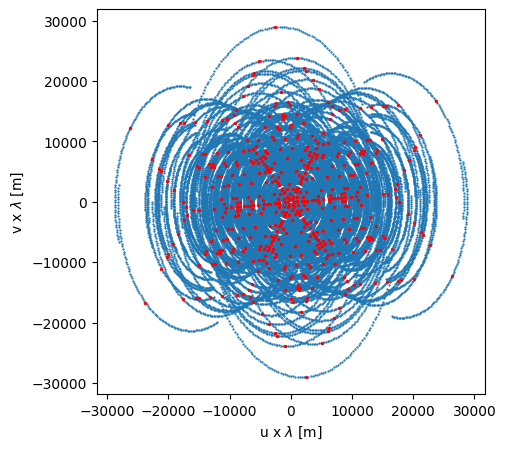

In [60]:
Y.time_integrate_baselines(lat=34, source_declination=34, track_time=8, delta_t=5/60, t_0=-4)
plot_uv_plane(Y.baselines, Y.n_baselines)

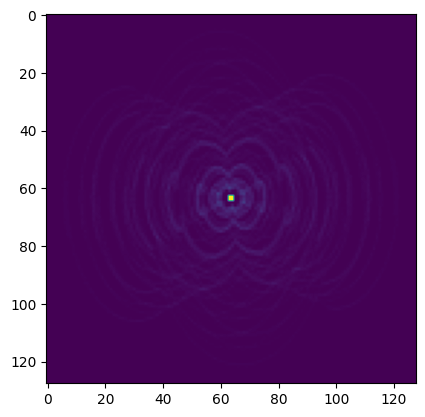

In [23]:
Y.compute_uv_plane()
plt.imshow(Y.uv_plane)
plt.show()